In [1]:
UPDATE = "asynchronous"
DIRECTORY = "models/random_nk3"
NUM_RUNS = 100
DEBUG = True

In [2]:
from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.state_transition_graphs import primes2stg

from transition_matrix import get_transition_matrix, get_uniform_matrix
from scc_dags import get_scc_dag, get_ordered_states, get_attractor_states
from matrix_operations import nsquare, compress_matrix, expand_matrix, get_confusion_matrix
from reachability import get_convergence_matrix
from basins import get_strong_basins
from grouping import sd_grouping, null_grouping, random_grouping


def get_data(bnet, data = {}, update="asynchronous", num_runs=100, DEBUG = False):

    # initialize data
    data["strong_basins"] = {}
    
    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}
    # Percolate constant nodes and remove them
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return data
    stg = primes2stg(percolated_primes, update)
    scc_dag = get_scc_dag(stg)
    scc_indices = get_ordered_states(scc_dag, as_indices=True, DEBUG=DEBUG)
    attractor_indices = get_attractor_states(scc_dag, as_indices=True, DEBUG=DEBUG)
    percolated_bnet = primes2bnet(percolated_primes)

    # Get strong_basins matrix for the transition matrix
    T = get_transition_matrix(stg, DEBUG=DEBUG)
    T_inf = nsquare(T, 20, DEBUG=DEBUG)
    T_convergence, _, _ = get_convergence_matrix(T_inf, scc_indices, attractor_indices, DEBUG=DEBUG)
    T_strong_basins = get_strong_basins(T_convergence, DEBUG=DEBUG)

    # Get strong_basins matrix for the sd grouped transition matrix
    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)
    Tsd_inf = nsquare(Tsd, 20, DEBUG=DEBUG)
    Tsd_inf_expanded = expand_matrix(Tsd_inf, sd_indices, DEBUG=DEBUG)
    Tsd_convergence, _, _ = get_convergence_matrix(Tsd_inf_expanded, scc_indices, attractor_indices, DEBUG=DEBUG)
    Tsd_strong_basins = get_strong_basins(Tsd_convergence, DEBUG=DEBUG)

    # Get strong_basins matrix for the null grouped transition matrix
    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    Tnull = compress_matrix(T, null_indices, DEBUG=DEBUG)
    Tnull_inf = nsquare(Tnull, 20, DEBUG=DEBUG)
    Tnull_inf_expanded = expand_matrix(Tnull_inf, null_indices, DEBUG=DEBUG)
    Tnull_convergence, _, _ = get_convergence_matrix(Tnull_inf_expanded, scc_indices, attractor_indices, DEBUG=DEBUG)
    Tnull_strong_basins = get_strong_basins(Tnull_convergence, DEBUG=DEBUG)

    # Get strong_basins matrix for the uniform matrix
    T_uniform = get_uniform_matrix(2**(len(percolated_primes)))
    Tuniform_convergence, _, _ = get_convergence_matrix(T_uniform, scc_indices, attractor_indices, DEBUG=DEBUG)
    Tuniform_strong_basins = get_strong_basins(Tuniform_convergence, DEBUG=DEBUG)

    # Get comparison results
    data["strong_basins"]["Tsd"] = get_confusion_matrix(T_strong_basins, Tsd_strong_basins, partial=True, DEBUG=DEBUG)
    data["strong_basins"]["Tnull"] = get_confusion_matrix(T_strong_basins, Tnull_strong_basins, partial=True, DEBUG=DEBUG)
    data["strong_basins"]["Tuniform"] = get_confusion_matrix(T_strong_basins, Tuniform_strong_basins, partial=True, DEBUG=DEBUG)

    # Get strong_basins matrix for the random matrix and get comparison results
    data["strong_basins"]["Trandom_TP"] = []
    data["strong_basins"]["Trandom_FP"] = []
    data["strong_basins"]["Trandom_TN"] = []
    data["strong_basins"]["Trandom_FN"] = []
    for i in range(num_runs):
        random_indices = random_grouping(sd_indices, null_indices, seed=i, DEBUG=DEBUG)
        Trandom = compress_matrix(T, random_indices, DEBUG=DEBUG)
        Trandom_inf = nsquare(Trandom, 20, DEBUG=DEBUG)
        Trandom_inf_expanded = expand_matrix(Trandom_inf, random_indices, DEBUG=DEBUG)
        Trandom_convergence, _, _ = get_convergence_matrix(Trandom_inf_expanded, scc_indices, attractor_indices, DEBUG=DEBUG)
        Trandom_strong_basins = get_strong_basins(Trandom_convergence, DEBUG=DEBUG)
        
        random_confusion = get_confusion_matrix(T_strong_basins, Trandom_strong_basins, partial=True, DEBUG=DEBUG)
        data["strong_basins"]["Trandom_TP"].append(random_confusion[0])
        data["strong_basins"]["Trandom_FP"].append(random_confusion[1])
        data["strong_basins"]["Trandom_TN"].append(random_confusion[2])
        data["strong_basins"]["Trandom_FN"].append(random_confusion[3])

    return data

In [3]:
import os

all_data = {}

# Iterate over the files in the directory
for filename in sorted(os.listdir(DIRECTORY)):

    file_path = os.path.join(DIRECTORY, filename)
    
    # Check if it's a file (not a directory)
    if not os.path.isfile(file_path):
        continue

    # Open and read the file
    with open(file_path, 'r') as file:
        print(f"Reading file: {filename}")
        content = file.read()
        
    data = get_data(bnet=content, data={}, update=UPDATE, num_runs=NUM_RUNS, DEBUG=DEBUG)

    all_data[filename] = data

Reading file: n010_000.bnet
Reading file: n010_001.bnet
Reading file: n010_002.bnet
Reading file: n010_003.bnet
Reading file: n010_004.bnet
duplicates={'000000001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000000101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000000111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000010100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010110': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000100001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000100100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], 

In [13]:
import numpy as np

for bnet in all_data:
    if len(all_data[bnet]["strong_basins"]) == 0:
        print(bnet)
        continue
    print(bnet,
          all_data[bnet]["strong_basins"]["Tsd"][0],
          all_data[bnet]["strong_basins"]["Tsd"][1],
          all_data[bnet]["strong_basins"]["Tsd"][2],
          all_data[bnet]["strong_basins"]["Tsd"][3],

          np.mean(all_data[bnet]["strong_basins"]["Trandom_TP"]),
          np.mean(all_data[bnet]["strong_basins"]["Trandom_FP"]),
          np.mean(all_data[bnet]["strong_basins"]["Trandom_TN"]),
          np.mean(all_data[bnet]["strong_basins"]["Trandom_FN"]),

          all_data[bnet]["strong_basins"]["Tnull"][0],
          all_data[bnet]["strong_basins"]["Tnull"][1],
          all_data[bnet]["strong_basins"]["Tnull"][2],
          all_data[bnet]["strong_basins"]["Tnull"][3],

          all_data[bnet]["strong_basins"]["Tuniform"][0],
          all_data[bnet]["strong_basins"]["Tuniform"][1],
          all_data[bnet]["strong_basins"]["Tuniform"][2],
          all_data[bnet]["strong_basins"]["Tuniform"][3],

          )

n010_000.bnet 584 0 384 0 8.0 0.0 384.0 576.0 8 0 384 576 0 0 384 584
n010_001.bnet 4 0 36 18 0.01 0.0 36.0 21.99 0 0 36 22 0 0 36 22
n010_002.bnet 127 0 0 0 127.0 0.0 0.0 0.0 127 0 0 0 127 0 0 0
n010_003.bnet 1023 0 0 0 1023.0 0.0 0.0 0.0 1023 0 0 0 1023 0 0 0
n010_004.bnet 120 0 326 62 0.0 0.0 326.0 182.0 0 0 326 182 0 0 326 182
n010_005.bnet 24 0 0 0 24.0 0.0 0.0 0.0 24 0 0 0 24 0 0 0
n010_006.bnet 94 0 892 36 0.0 0.0 892.0 130.0 0 0 892 130 0 0 892 130
n010_007.bnet 3 0 500 7 0.0 0.0 500.0 10.0 0 0 500 10 0 0 500 10
n010_008.bnet 96 0 112 14 0.0 0.0 112.0 110.0 0 0 112 110 0 0 112 110
n010_009.bnet 48 0 110 2 33.0 0.0 110.0 17.0 33 0 110 17 0 0 110 50
n010_010.bnet
n010_011.bnet 225 0 232 20 0.0 0.0 232.0 245.0 0 0 232 245 0 0 232 245
n010_012.bnet 1023 0 0 0 1023.0 0.0 0.0 0.0 1023 0 0 0 1023 0 0 0
n010_013.bnet 11 0 2 0 0.17 0.0 2.0 10.83 0 0 2 11 0 0 2 11
n010_014.bnet 4 0 0 0 4.0 0.0 0.0 0.0 4 0 0 0 4 0 0 0
n010_015.bnet 22 0 972 20 0.0 0.0 972.0 42.0 0 0 972 42 0 0 972 42
n010

In [11]:
import matplotlib.pyplot as plt

def plot_recall_and_NPV(TP, FP, TN, FN):

    # Lists to store recall and NPV values
    recalls = []
    NPVs = []

    # Calculate recall and NPV for each set of values
    for i in range(len(TP)):
        tp = TP[i]
        fp = FP[i]
        tn = TN[i]
        fn = FN[i]
        
        # Calculate recall and NPV
        if tp + fn != 0:
            recall = tp / (tp + fn)
            recalls.append(recall)
        if tn + fn != 0:
            NPV = tn / (tn + fn)
            NPVs.append(NPV)
            
    # Create histograms of recall and NPV
    plt.figure(figsize=(10, 6))

    # Plotting the histogram for Recall
    plt.subplot(1, 2, 1)
    plt.hist(recalls, bins=10, color='green', alpha=0.7)
    plt.title('Recall Histogram')
    plt.xlabel('Recall')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 50)

    # Plotting the histogram for NPV
    plt.subplot(1, 2, 2)
    plt.hist(NPVs, bins=10, color='blue', alpha=0.7)
    plt.title('NPV Histogram')
    plt.xlabel('NPV')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 50)


    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


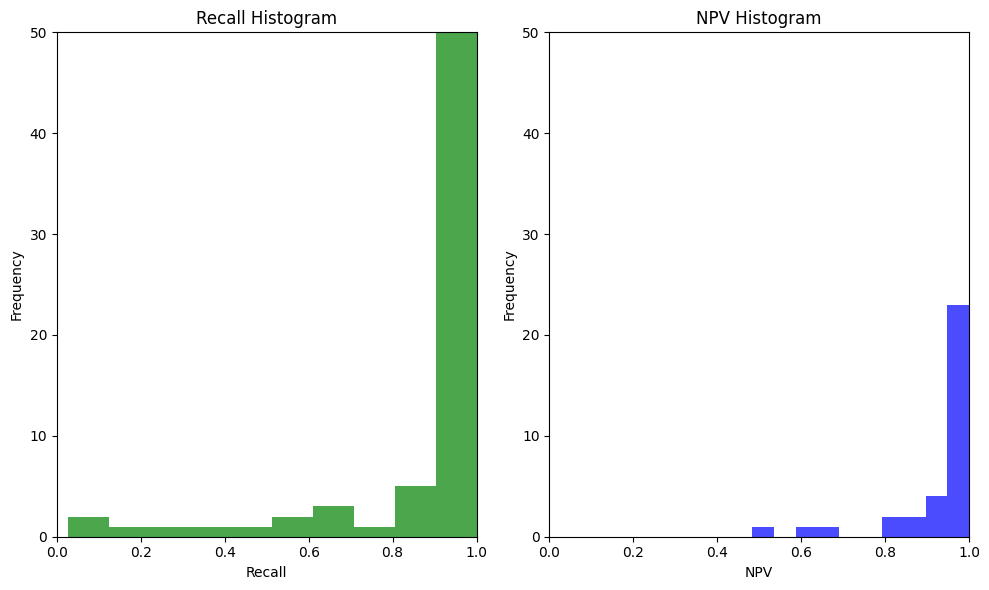

In [12]:
TP = []
FP = []
TN = []
FN = []
for bnet in all_data:
    if len(all_data[bnet]["strong_basins"]) == 0:
        continue
    TP.append(all_data[bnet]["strong_basins"]["Tsd"][0])
    FP.append(all_data[bnet]["strong_basins"]["Tsd"][1])
    TN.append(all_data[bnet]["strong_basins"]["Tsd"][2])
    FN.append(all_data[bnet]["strong_basins"]["Tsd"][3])

print(np.arange(0, 1.1, 0.1))

plot_recall_and_NPV(TP, FP, TN, FN)